In [31]:
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
from pandas.plotting import scatter_matrix
import requests
import json
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import sklearn.tree as tree
import graphviz

In [32]:
# plotly setup
username = 'pablodm' # your username
api_key = '<api key>' # censored
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [33]:
# mongodb setup
client = MongoClient('mongodb+srv://pablodm:<password>@cluster0.qzcor.mongodb.net') # password censored
db=client.siot_weather
# Issue the serverStatus command and print the results
serverStatusResult=db.command("serverStatus")
pprint(serverStatusResult)

{'$clusterTime': {'clusterTime': Timestamp(1640116455, 1),
                  'signature': {'hash': b'\xc9\x81{\x87\xb7b\xc2\xab=\xc4\xa71'
                                        b'\xceSU&f\xa1\xea\x8a',
                                'keyId': 7005518867288031243}},
 'asserts': {'msg': 0, 'regular': 0, 'rollovers': 0, 'user': 0, 'warning': 0},
 'atlasVersion': {'gitVersion': 'ef0b9135a55ff437262ea111b3f103664c758ab9',
                  'version': '20211202.0.0.1638213056'},
 'connections': {'available': 496, 'current': 4, 'totalCreated': 210},
 'extra_info': {'note': 'fields vary by platform', 'page_faults': 0},
 'host': 'cluster0-shard-00-01.qzcor.mongodb.net:27017',
 'localTime': datetime.datetime(2021, 12, 21, 19, 54, 15, 21000),
 'mem': {'bits': 64,
         'mapped': 0,
         'mappedWithJournal': 0,
         'resident': 0,
         'supported': True,
         'virtual': 0},
 'metrics': {'aggStageCounters': {'search': 0, 'searchBeta': 0},
             'atlas': {'connectionPool'

In [34]:
# create two dataframes, one for esp data and another one for Open Weather Map API data. fill them with the information from the respective collection on mongodb
esp = pd.DataFrame(list(db.esp_data.find()))
owm = pd.DataFrame(list(db.owm_data.find()))

#sort rows by time 
esp = esp.sort_values(by="datetime")
owm = owm.sort_values(by="c_time")

# delete minute, second and microsecond as they are not useful
for i in range(len(esp["datetime"])):
    esp.at[i, "datetime"] = esp.at[i, "datetime"].replace(minute=0, second=0, microsecond=0)
for i in range(len(owm["c_time"])):
    owm.at[i, "c_time"] = owm.at[i, "c_time"].replace(minute=0, second=0, microsecond=0)

esp.head()
owm.head()

,_id,c_clouds,c_feels,c_humidity,c_pressure,c_temp,c_time,c_weather_desc,c_weather_main,c_wind_speed,p_clouds,p_feels,p_humidity,p_pressure,p_temp,p_time,p_weather_desc,p_weather_main,p_wind_speed
0,61addf39f20c163172494cb6,75,1.36,93,1011,4.10,2021-12-06 10:00:00,haze,Haze,3.09,13,1.36,65,989,5.68,2021-12-08 09:00:00,few clouds,Clouds,7.08
1,61aded417d69520b1f0efd3c,90,2.27,90,1010,4.86,2021-12-06 11:00:00,moderate rain,Rain,3.09,33,2.03,62,990,6.19,2021-12-08 10:00:00,scattered clouds,Clouds,7.04
2,61adfb527d69520b1f0efd3d,75,2.59,92,1008,5.40,2021-12-06 12:00:00,broken clouds,Clouds,3.60,33,2.52,60,990,6.68,2021-12-08 11:00:00,scattered clouds,Clouds,7.48
3,61ae09647d69520b1f0efd3e,75,3.77,91,1006,6.10,2021-12-06 13:00:00,light rain,Rain,3.09,44,2.73,61,990,6.81,2021-12-08 12:00:00,scattered clouds,Clouds,7.33
4,61ae17767d69520b1f0efd3f,75,3.09,89,1005,6.45,2021-12-06 14:00:00,light rain,Rain,5.14,100,2.89,63,991,6.86,2021-12-08 13:00:00,overcast clouds,Clouds,7.03


In [35]:
# create function to calculate average
def average(lst):
    return sum(lst) / len(lst)

#create a new dataframe to store all weather info
weather = pd.DataFrame()

# add a row for each hour to the dataframe, with the four types of information: 
#   - the weather at that time according to the api (c_ for current)
#   - the weather prediction that was made for that time 48 hours ago (p_ for prediction)
#   - the weather sensed by the sensors at that time (s_ for sensed)
#   - the error in the prediction, defined as: the predicted value - the sensed value
for i in range(owm.shape[0]):
    a = owm.iloc[i][["c_time", "c_temp", "c_feels", "c_pressure", "c_humidity", "c_clouds", "c_wind_speed", "c_weather_main", "c_weather_desc"]]
    sample_dict = a.to_dict()

    b_index = owm.index[owm["p_time"] == owm.iloc[i]["c_time"].replace(second=0)]
    if len(b_index.tolist())>0:
        b = owm.loc[b_index[0], ["p_temp", "p_feels", "p_pressure", "p_humidity", "p_clouds", "p_wind_speed", "p_weather_main", "p_weather_desc"]]
        sample_dict.update(b)

    c_index = esp.index[esp["datetime"] == owm.iloc[i]["c_time"].replace(second=0)]
    # s_ data was sampled at three times per hour, the values are averaged to have a single value per hour
    if len(c_index.tolist())>0:
        avg_temp   = round(average(esp.iloc[c_index]["temp"]), 2)
        avg_hum    = round(average(esp.iloc[c_index]["hum"]), 2)
        avg_heat_i = round(average(esp.iloc[c_index]["heat_i"]), 2)
        avg_rain   = round(average(esp.iloc[c_index]["rain"]), 2)
        c = {"s_temp": avg_temp, "s_humidity": avg_hum, "s_feels": avg_heat_i, "s_rain": avg_rain}
        sample_dict.update(c)

    #calculate errors 
    if len(b_index.tolist())>0 and len(c_index.tolist())>0:
        d = {"temp_error":   sample_dict["p_temp"]     - sample_dict["s_temp"], 
             "hum_error":    sample_dict["p_humidity"] - sample_dict["s_humidity"], 
             "feels_error":  sample_dict["p_feels"]    - sample_dict["s_feels"]}
        sample_dict.update(d)
        weather = weather.append(sample_dict, ignore_index=True)

weather.to_csv("weather.csv")


In [36]:
# if you want to run the code, uncomment the following line and skip all previous cells: 
# weather = pd.read_csv("weather.csv")

# from weather, we now create a copy and delete all temperature-related columns except temp_error
weather_noT = weather.drop(columns=["c_time", "c_temp", "c_feels", "p_temp", "p_feels", "s_temp", "s_feels", "feels_error"])
weather_noT.head()

# we now create a copy of this df to prepare it for machine learning
# binarise categorical columns
weather_ml = pd.get_dummies(weather_noT)

weather_ml['temp_error'] = weather_ml['temp_error'].astype(float)
# slice the class variable into 4 bins
weather_ml["te_quantiles"] = pd.cut(weather_ml['temp_error'], bins=4)
weather_ml = weather_ml.drop(columns=["temp_error"])
print(weather_ml.groupby("te_quantiles").size())

# replace the bin with 0-3 integers 
bins_list = sorted(weather_ml["te_quantiles"].unique().tolist())
for i in range(len(weather_ml["te_quantiles"])):
    weather_ml.at[i, "te_quantiles_int"] = int(bins_list.index(weather_ml.at[i, "te_quantiles"]))

weather_ml = weather_ml.drop(columns=["te_quantiles"])
print(weather_ml.groupby("te_quantiles_int").size())

# only keep the p_ columns and te_quantiles_int as they will be the ones we want to use in the model (we want to build it so that it only uses prediction information to predict the error)
to_drop = []
for c in range(len(weather_ml.columns.tolist())):
    if not str(weather_ml.columns.tolist()[c]).startswith("p_"):
        to_drop.append(weather_ml.columns.tolist()[c])
to_drop.remove("te_quantiles_int")
weather_p = weather_ml.drop(columns=to_drop)

print("weather\n", weather)
print("weather_ml\n", weather_ml)
print("weather_p\n", weather_p)

te_quantiles
(-6.439, -4.22]    14
(-4.22, -2.01]     31
(-2.01, 0.2]       83
(0.2, 2.41]        43
dtype: int64
te_quantiles_int
0.0    14
1.0    31
2.0    83
3.0    43
dtype: int64
weather
      c_clouds  c_feels  c_humidity  c_pressure  c_temp              c_time  \
0        75.0     3.50        69.0       990.0    7.49 2021-12-08 11:00:00   
1        75.0     3.76        70.0       990.0    7.81 2021-12-08 12:00:00   
2        75.0     4.23        70.0       991.0    8.06 2021-12-08 13:00:00   
3        75.0     4.40        67.0       992.0    8.07 2021-12-08 14:00:00   
4        75.0     4.14        67.0       992.0    7.87 2021-12-08 15:00:00   
5        40.0     3.23        67.0       993.0    7.29 2021-12-08 16:00:00   
6        40.0     3.16        68.0       994.0    6.68 2021-12-08 17:00:00   
7         0.0     2.39        68.0       995.0    6.38 2021-12-08 18:00:00   
8        40.0     2.18        69.0       996.0    6.35 2021-12-08 19:00:00   
9         0.0     1.96     

In [37]:
autoopen = True
# make plots for each of the variables of interest
fig = px.line(weather, x="c_time", y=["s_temp", "c_temp", "p_temp", "temp_error"], labels={'c_time': 'Time'})
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()
#py.plot(fig, filename = 'temperature', auto_open=autoopen)

fig = px.line(weather, x="c_time", y=["s_feels", "c_feels", "p_feels", "feels_error"], labels={'c_time': 'Time'})
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()
#py.plot(fig, filename = 'feels', auto_open=autoopen)

fig = px.line(weather, x="c_time", y=["s_humidity", "c_humidity", "p_humidity", "hum_error"], labels={'c_time': 'Time'})
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()
#py.plot(fig, filename = 'humidity', auto_open=autoopen)

fig = px.line(weather, x="c_time", y=["c_pressure", "p_pressure"], labels={'c_time': 'Time'})
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()
#py.plot(fig, filename = 'pressure', auto_open=autoopen)

fig = px.line(weather, x="c_time", y=["c_wind_speed", "p_wind_speed"], labels={'c_time': 'Time'})
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()
#py.plot(fig, filename = 'wind', auto_open=autoopen)

fig = px.line(weather, x="c_time", y=["c_clouds", "p_clouds"], labels={'c_time': 'Time'})
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()
#py.plot(fig, filename = 'clouds', auto_open=autoopen)

fig = px.line(weather, x="c_time", y=["c_weather_desc", "p_weather_desc"], labels={'c_time': 'Time'})
fig.update_yaxes(categoryorder='trace')
#["clear sky", "few clouds", "scattered clouds", "broken clouds", "overcast clouds", "light intensity drizzle", "light rain", "moderate rain", "heavy inteensity rain"])
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
fig.show()
#py.plot(fig, filename = 'description', auto_open=autoopen)

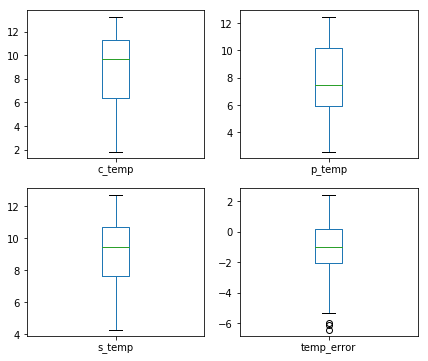

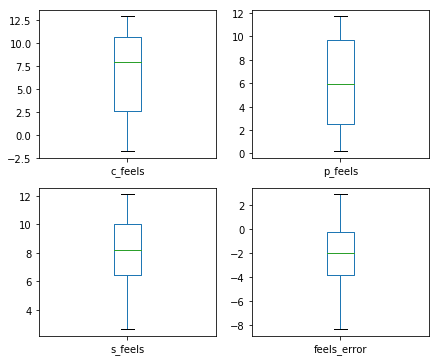

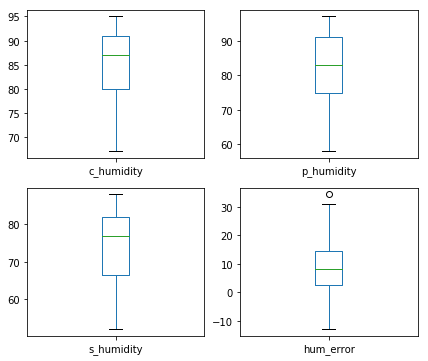

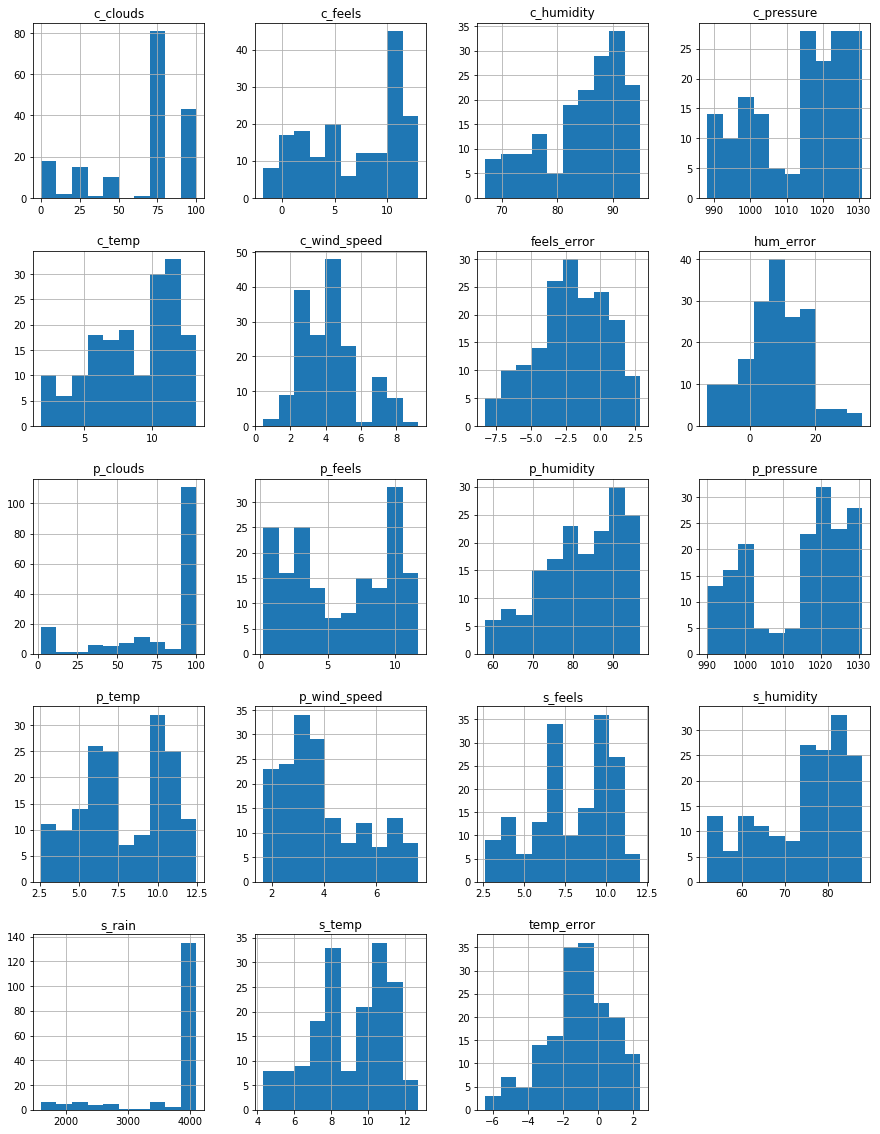

In [38]:
# make plots to show the distirbution of the variables

pyplot.rcParams["figure.facecolor"] = "FFFFFF"
pyplot.rcParams["axes.facecolor"] = "FFFFFF"
pyplot.rcParams["figure.figsize"] = (7, 6)

weather[["c_temp", "p_temp", "s_temp", "temp_error"]].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
pyplot.show()

weather[["c_feels", "p_feels", "s_feels", "feels_error"]].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
pyplot.show()

weather[["c_humidity", "p_humidity", "s_humidity", "hum_error"]].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
pyplot.show()

weather.hist(figsize=(15,20))
pyplot.show()

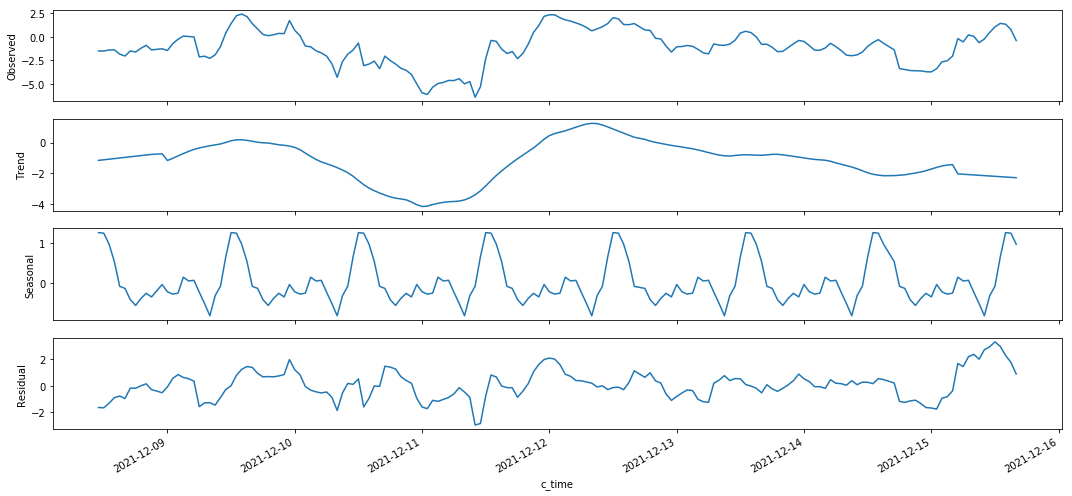

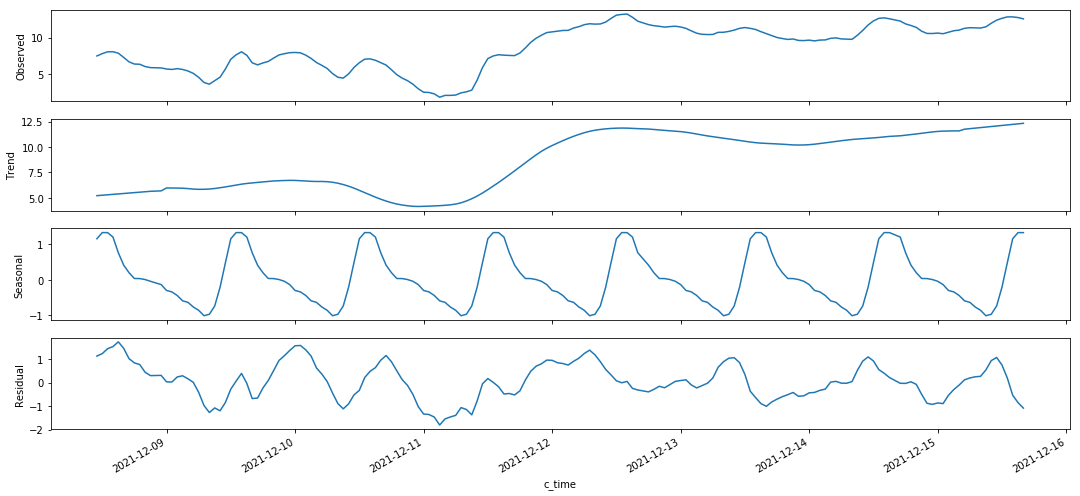

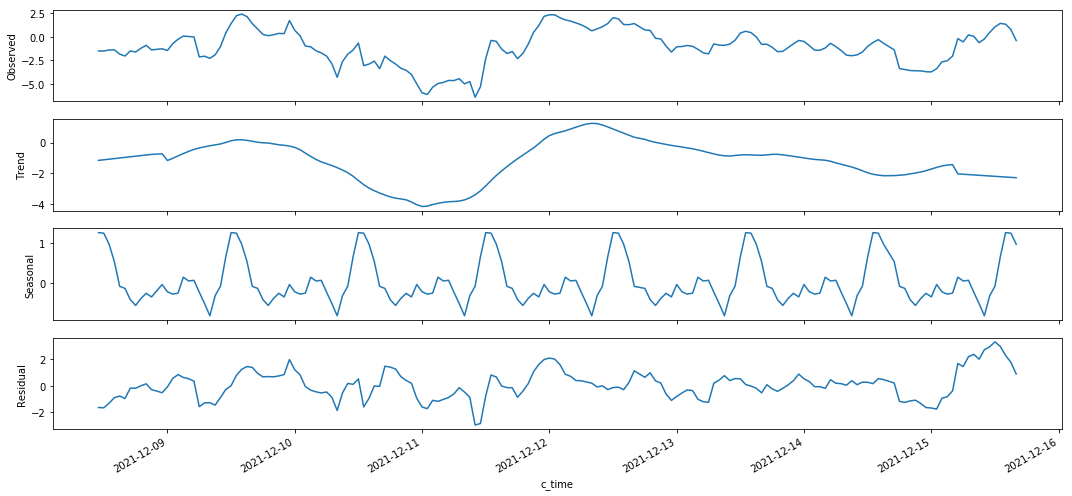

In [39]:
# seasonality analysis

# this function sets the specified column as the index
def set_date_index(input_df, col_name='time'):
    modified_df = input_df.copy()
    modified_df[col_name] = pd.to_datetime(modified_df[col_name])
    modified_df.sort_values(col_name, inplace=True)
    modified_df.set_index(col_name, inplace=True)
    return modified_df


# seasonal analysis for c_temp
weather_sea = weather.loc[:, ["c_time", "c_temp"]]
weather_sea = set_date_index(weather_sea, 'c_time')

sd = seasonal_decompose(weather_sea, extrapolate_trend='freq', freq=24)
weather_sea['observed'] = sd.observed
weather_sea['residual'] = sd.resid
weather_sea['seasonal'] = sd.seasonal
weather_sea['trend']    = sd.trend

fig = px.line(weather_sea, x = weather_sea.index, y=["c_temp", "residual", "seasonal", "trend"], labels={'c_time': 'Time'})
fig.update_layout(xaxis = dict(rangeslider = dict(visible=True)))
fig.show()
#py.plot(fig, filename = 'seasonality_temp', auto_open=False)

pyplot.rcParams["figure.figsize"] = (15, 7)
pyplot.rcParams["figure.facecolor"] = "FFFFFF"
pyplot.rcParams["axes.facecolor"] = "FFFFFF"
sd.plot()


# seasonal analysis for temp_error
weather_sea = weather.loc[:, ["c_time", "temp_error"]]
weather_sea = set_date_index(weather_sea, 'c_time')

sd = seasonal_decompose(weather_sea, extrapolate_trend='freq', freq=24)
weather_sea['observed'] = sd.observed
weather_sea['residual'] = sd.resid
weather_sea['seasonal'] = sd.seasonal
weather_sea['trend'] = sd.trend

fig = px.line(weather_sea, x=weather_sea.index, y=["temp_error", "residual", "seasonal", "trend"], labels={'c_time': 'Time'})
fig.update_layout(xaxis = dict(rangeslider = dict(visible=True)))
fig.show()
# py.plot(fig, filename = 'seasonality_error', auto_open=True);

pyplot.rcParams["figure.figsize"] = (15, 7)
pyplot.rcParams["figure.facecolor"] = "FFFFFF"
pyplot.rcParams["axes.facecolor"] = "FFFFFF"
sd.plot()

In [40]:
# correlation analysis

corr = weather_noT.corr()
print(corr)

              c_clouds  c_humidity  c_pressure  c_wind_speed  hum_error  \
c_clouds      1.000000    0.390931    0.306445     -0.148124   0.362636   
c_humidity    0.390931    1.000000    0.479660     -0.532933   0.291397   
c_pressure    0.306445    0.479660    1.000000     -0.539693  -0.184243   
c_wind_speed -0.148124   -0.532933   -0.539693      1.000000  -0.062075   
hum_error     0.362636    0.291397   -0.184243     -0.062075   1.000000   
p_clouds      0.463799    0.347540    0.060084     -0.027597   0.413647   
p_humidity    0.464786    0.815726    0.616979     -0.567354   0.451288   
p_pressure    0.302801    0.520447    0.993812     -0.548388  -0.169350   
p_wind_speed -0.167687   -0.451174   -0.716896      0.721485  -0.017536   
s_humidity    0.127669    0.540146    0.779209     -0.504475  -0.469534   
s_rain        0.180256   -0.222992   -0.035418     -0.000252   0.416440   
temp_error    0.315037    0.025581    0.041219      0.069167  -0.044693   

              p_clouds  

In [41]:
# correlation analysis

df = weather_noT.corr()

# prints resulsts of three types of correlation and their corresponding p-value
for i in range(len(df.transpose().values.tolist())):
    print(i, "correlation of temp_error with", df.transpose().columns.tolist()[i])
    print(scipy.stats.pearsonr(df.temp_error, df.transpose().values.tolist()[i]), scipy.stats.spearmanr(df.temp_error, df.transpose().values.tolist()[i]), scipy.stats.kendalltau(df.temp_error, df.transpose().values.tolist()[i]),)

0 correlation of temp_error with c_clouds
(0.2608448542543904, 0.41286030861212775) SpearmanrResult(correlation=0.32867132867132864, pvalue=0.2969041156887641) KendalltauResult(correlation=0.2424242424242424, pvalue=0.27257111883252905)
1 correlation of temp_error with c_humidity
(-0.08045569422127212, 0.8037025126660327) SpearmanrResult(correlation=0.055944055944055944, pvalue=0.8628980736949712) KendalltauResult(correlation=-0.0303030303030303, pvalue=0.8909161075445843)
2 correlation of temp_error with c_pressure
(-0.08450508443116996, 0.7940056891466251) SpearmanrResult(correlation=0.1188811188811189, pvalue=0.712884219214772) KendalltauResult(correlation=0.0, pvalue=1.0)
3 correlation of temp_error with c_wind_speed
(0.09519664418529529, 0.7685347874566963) SpearmanrResult(correlation=0.1398601398601399, pvalue=0.6646331617926677) KendalltauResult(correlation=0.1212121212121212, pvalue=0.5832934499147818)
4 correlation of temp_error with hum_error
(-0.14051806171832204, 0.66313763

In [42]:
fig = px.line(weather, x="c_time", y=["temp_error", "c_clouds", "p_clouds"])
fig.show()
#py.plot(fig, filename = 'clouds correlation', auto_open=True)

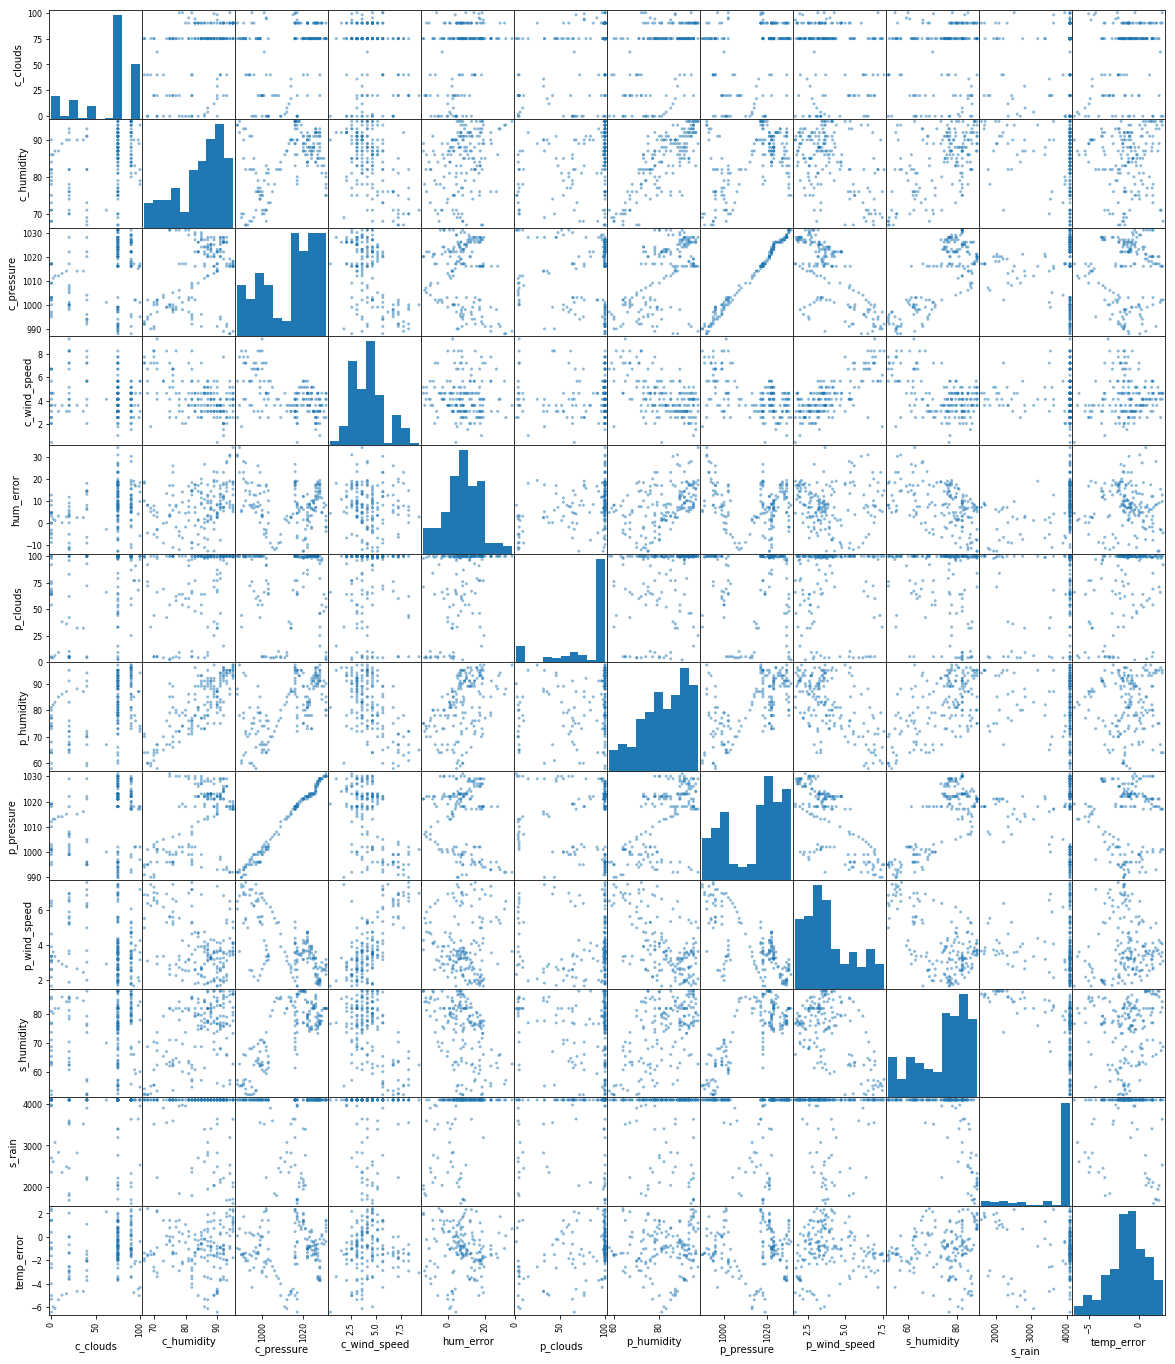

In [43]:
# matrix to explore correlations of all variables to all variables

pyplot.rcParams["figure.facecolor"] = "FFFFFF"
pyplot.rcParams["axes.facecolor"] = "FFFFFF"
scatter_matrix(weather_noT, figsize=(20,24))
pyplot.show()

In [44]:
# create X, y splits for machine learning

column_pick = "te_quantiles_int"
dataset = weather_p
X = dataset.loc[:, dataset.columns != column_pick]
y = dataset.loc[:, dataset.columns == column_pick]
    
X_train, X_validation = train_test_split(X, test_size=0.2, random_state=0)
y_train, y_validation = train_test_split(y, test_size=0.2, random_state=0) 

    
print('X_train: {}, y_train: {}'.format(len(X_train), len(y_train)))
print('X_validation: {}, y_validation: {}'.format(len(X_validation), len(y_validation)))

X_train: 136, y_train: 136
X_validation: 35, y_validation: 35


LR: 0.570271 (0.138146)
0.5614035087719298
[[ 2  5  2  5]
 [ 4 10 14  3]
 [ 1  2 71  9]
 [ 1  3 26 13]]
              precision    recall  f1-score   support

         0.0       0.25      0.14      0.18        14
         1.0       0.50      0.32      0.39        31
         2.0       0.63      0.86      0.72        83
         3.0       0.43      0.30      0.36        43

   micro avg       0.56      0.56      0.56       171
   macro avg       0.45      0.41      0.41       171
weighted avg       0.53      0.56      0.53       171

LDA: 0.564756 (0.160554)
0.5555555555555556
[[ 4  4  1  5]
 [ 3 10 13  5]
 [ 2  2 68 11]
 [ 3  3 24 13]]
              precision    recall  f1-score   support

         0.0       0.33      0.29      0.31        14
         1.0       0.53      0.32      0.40        31
         2.0       0.64      0.82      0.72        83
         3.0       0.38      0.30      0.34        43

   micro avg       0.56      0.56      0.56       171
   macro avg       0.47      0

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklear

DT: 0.678007 (0.087112)
0.672514619883041
[[10  0  1  3]
 [ 0 18  8  5]
 [ 3 10 60 10]
 [ 1  3 12 27]]
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71        14
         1.0       0.58      0.58      0.58        31
         2.0       0.74      0.72      0.73        83
         3.0       0.60      0.63      0.61        43

   micro avg       0.67      0.67      0.67       171
   macro avg       0.66      0.66      0.66       171
weighted avg       0.67      0.67      0.67       171

NB: 0.393885 (0.100385)
0.39766081871345027
[[13  0  1  0]
 [15  1  9  6]
 [ 9  2 24 48]
 [ 9  0  4 30]]
              precision    recall  f1-score   support

         0.0       0.28      0.93      0.43        14
         1.0       0.33      0.03      0.06        31
         2.0       0.63      0.29      0.40        83
         3.0       0.36      0.70      0.47        43

   micro avg       0.40      0.40      0.40       171
   macro avg       0.40      0.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/pabloduran/anaconda3/lib/python3.7/sit

              precision    recall  f1-score   support

         0.0       0.33      0.07      0.12        14
         1.0       0.61      0.35      0.45        31
         2.0       0.57      0.96      0.72        83
         3.0       0.70      0.16      0.26        43

   micro avg       0.58      0.58      0.58       171
   macro avg       0.55      0.39      0.39       171
weighted avg       0.59      0.58      0.51       171



/Users/pabloduran/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



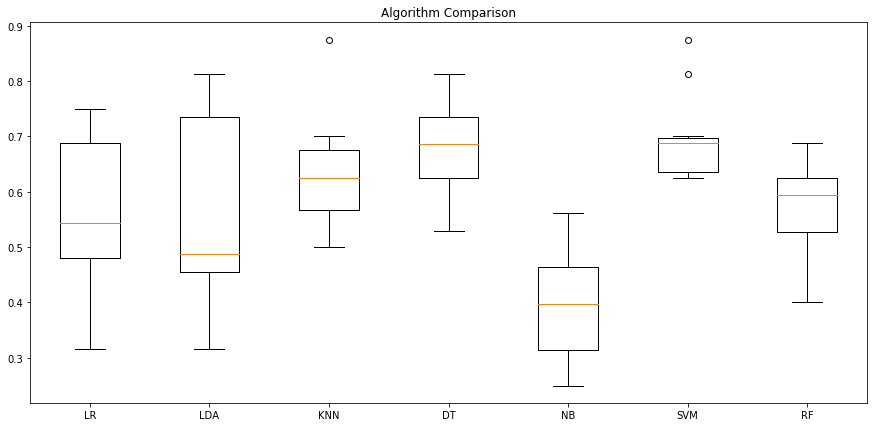

In [45]:
# Machine Learning

# create list of all models we want to try
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='auto')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(max_depth=4)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RF', RandomForestClassifier(max_depth=2, min_samples_split=4)))
# evaluate each model in turn
results = []
names = []
for i, (name, model) in enumerate(models):
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y.values.ravel(), cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

	y_pred = cross_val_predict(model, X, y.values.ravel(), cv=kfold)

	print(accuracy_score(y, y_pred))
	print(confusion_matrix(y, y_pred))
	print(classification_report(y, y_pred))

# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
ax = pyplot.axes()
ax.set_facecolor("white")
pyplot.show()

/Users/pabloduran/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.




For the validation set:
Accuracy: 	0.5428571428571428
Precision: 	[0.         1.         0.5        0.66666667]
Recall: 	[0.         0.22222222 0.9375     0.33333333]
[[ 0  0  4  0]
 [ 0  2  7  0]
 [ 0  0 15  1]
 [ 0  0  4  2]]


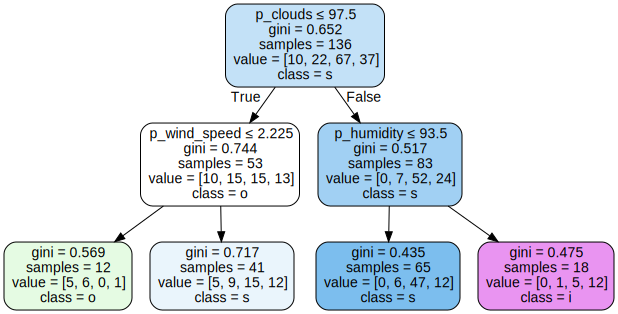

In [46]:
#DecisionTree
dt = tree.DecisionTreeClassifier(max_depth = 2) # Our classification tree
dt = dt.fit(X_train, y_train) 

print('\nFor the validation set:')
print('Accuracy: \t{}'.format(accuracy_score(y_validation, dt.predict(X_validation)))) #y, best_predictions)))#
print('Precision: \t{}'.format(precision_score(y_validation, dt.predict(X_validation), average=None)))
print('Recall: \t{}'.format(recall_score(y_validation, dt.predict(X_validation), average=None))) 
print(confusion_matrix(y_validation, dt.predict(X_validation)))

predictors = X_train.columns
dot_data = tree.export_graphviz(dt, out_file=None, feature_names = predictors, class_names = ('Positive'), filled = True, rounded = True, special_characters = True) #(dt, out_file=None, feature_names = predictors, class_names = ('Negative', 'Positive'), filled = True, rounded = True, special_characters = True)
graph = graphviz.Source(dot_data)
graph

In [49]:
# api setup
api_key = "<api key>" #api key censored
lat = "51.49172012646749"
lon = "-0.1953124719660753"
url = "https://api.openweathermap.org/data/2.5/onecall?lat=%s&lon=%s&appid=%s&units=metric" % (lat, lon, api_key)

# get data from OWM API
response = requests.get(url)
    #format data as json
data = json.loads(response.text)

# format data appropiately 
Xnew = {
    "p_clouds": data["hourly"][-1]["clouds"],
    "p_humidity": data["hourly"][-1]["humidity"],
    "p_pressure": data["hourly"][-1]["pressure"],
    "p_wind_speed": data["hourly"][-1]["wind_speed"],
    "p_weather_desc_broken clouds": int("p_weather_desc_broken clouds".split("_")[-1]==data["hourly"][-1]["weather"][0]["description"]),
    "p_weather_desc_clear sky": int("p_weather_desc_clear sky".split("_")[-1]==data["hourly"][-1]["weather"][0]["description"]),
    "p_weather_desc_few clouds": int("p_weather_desc_few clouds".split("_")[-1]==data["hourly"][-1]["weather"][0]["description"]),
    "p_weather_desc_light rain": int("p_weather_desc_light rain".split("_")[-1]==data["hourly"][-1]["weather"][0]["description"]),
    "p_weather_desc_moderate rain": int("p_weather_desc_moderate rain".split("_")[-1]==data["hourly"][-1]["weather"][0]["description"]),
    "p_weather_desc_overcast clouds": int("p_weather_desc_overcast clouds".split("_")[-1]==data["hourly"][-1]["weather"][0]["description"]),
    "p_weather_desc_scattered clouds": int("p_weather_desc_scattered clouds".split("_")[-1]==data["hourly"][-1]["weather"][0]["description"]),
    "p_weather_main_Clear": int("p_weather_main_Clear".split("_")[-1]==data["hourly"][-1]["weather"][0]["main"]),
    "p_weather_main_Clouds": int("p_weather_main_Clouds".split("_")[-1]==data["hourly"][-1]["weather"][0]["main"]),
    "p_weather_main_Rain": int("p_weather_main_Rain".split("_")[-1]==data["hourly"][-1]["weather"][0]["main"])
}

Xnewdf = pd.DataFrame.from_dict(Xnew, orient='index').transpose()

# feed data to model to make prediciton of error range
ynew = int(dt.predict(Xnewdf)[0])
print("Temperature error is predicted to be in category " +  str(ynew) + ":", bins_list[ynew])

Temperature error is predicted to be in category 3: (0.2, 2.41]
